Pytorch is easier to debug, I like it.

Refs: 
- implementations:
    - PPO
        - **pytorch implementation https://github.com/alexis-jacq/Pytorch-DPPO/blob/master/ppo.py**
        - tensorflow implementation https://github.com/reinforceio/tensorforce/blob/master/tensorforce/models/ppo_model.py
    - Prioritised memory
    - Other
        - http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training
        - https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py
- papers:
    - DPPO https://arxiv.org/pdf/1707.02286.pdf
    - PPO 
        - https://arxiv.org/abs/1707.06347
        - https://blog.openai.com/openai-baselines-ppo/
    - TRPO https://arxiv.org/abs/1502.05477

In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime
import random

from collections import OrderedDict
from IPython.display import display
from pprint import pprint

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import argparse
import os
import sys
import gym
from gym import wrappers
import random
import numpy as np

import torch
import torch.optim as optim
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [4]:
class Params():
    def __init__(self):
        # env
        self.window_length = 50
        # Model
        self.batch_size = 250
        self.lr = 3e-4
        self.gamma = 0.00
        self.gae_param = 0.95
        self.clip = 0.2 # epsilon from eq 7, default 0.2
        self.ent_coeff = 0.
        self.num_epoch = 10
        self.num_steps = 2048
        self.time_horizon = 2000000
        self.max_episode_length = 10000
        self.seed = 1

params = Params()

save_path= 'outputs/agent_portfolio-ddpo/{}_seperate_weights.pickle'.format('2017-07-21')
try:
    os.makedirs(os.path.dirname(save_path))
except OSError:
    pass
save_path

'outputs/agent_portfolio-ddpo/2017-07-21_seperate_weights.pickle'

# Memory
refs
- https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
- https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py

In [5]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, events):
        for event in zip(*events):
            self.memory.append(event)
            if len(self.memory)>self.capacity:
                del self.memory[0]

    def clear(self):
        self.memory = []

    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: torch.cat(x, 0), samples)

# Enviroment

In [8]:
from src.environments.portfolio import PortfolioEnv, sharpe, max_drawdown

# we want to pemute the channels a little

class PermutedPortfolioEnv(PortfolioEnv):
    def reset(self, *args, **kwargs):
        return np.transpose(super().reset(*args, **kwargs),(0,1,2))
    def step(self, *args, **kwargs):
        observation, reward, done, info = super().step(*args, **kwargs)
        observation = np.transpose(observation,(2,0,1))
        return observation, reward, done, info


df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env = PermutedPortfolioEnv(
    df=df_train,
    steps=128, 
    scale=True, 
    augment=0.00025, # let just overfit first,
    trading_cost=0, #0.0025, # let just overfit first,
    window_length = params.window_length,   
)
env.seed(params.seed)
env.reset().shape

df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = PermutedPortfolioEnv(
    df=df_test,
    steps=1280, 
    scale=True, 
    augment=0.00025, # let just overfit first,
    trading_cost=0, #0.0025, # let just overfit first,
    window_length = params.window_length,   
)
env_test.seed(params.seed)
env_test.reset().shape

(3, 5, 50)

# Model

In [9]:
class GenericSharedModel(nn.Module):
    def __init__(self, inputs, outputs):
        super(GenericSharedModel, self).__init__()
        num_inputs = int(np.prod(env.observation_space.shape))
        num_outputs = int(np.prod(env.action_space.shape))
        
        # hidden layer sizes
        h_size_1 = 64
        h_size_2 = 64
        
        self.conv1 = nn.Conv2d(3, 2, (1, 3))
        self.conv2 = nn.Conv2d(2, 20, (1, inputs[1] - 2))
        
        self.fc1 = nn.Linear(100, h_size_1)
        self.fc2 = nn.Linear(h_size_1, h_size_2)
        
        self.mu = nn.Linear(h_size_2, num_outputs)
        self.log_std = nn.Parameter(torch.zeros(num_outputs))
        
        
        self.fc1b = nn.Linear(100, h_size_1)
        self.fc2b = nn.Linear(h_size_1, h_size_2)
        
        self.v = nn.Linear(h_size_2,1)
        
        for name, p in self.named_parameters():
            # init parameters
            if 'bias' in name:
                p.data.fill_(0)
            '''
            if 'mu.weight' in name:
                p.data.normal_()
                p.data /= torch.sum(p.data**2,0).expand_as(p.data)'''
        
        # mode
        self.train()

    def forward(self, inputs):
        # flatten
#         inputs = inputs.view((inputs.size()[0],-1))
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        h = x.view(x.size(0),-1) # Flatten
        
        # actor
        x = F.tanh(self.fc1(h))
        x = F.tanh(self.fc2(x))
        
        # the action
        mu = F.softmax(self.mu(x))
        
        # exploration multiplier
        log_std = F.sigmoid(torch.exp(self.log_std).unsqueeze(0).expand_as(mu))
        
        # critic
        x = F.tanh(self.fc1(h))
        x = F.tanh(self.fc2(x))
        v = self.v(x)
        return mu, log_std, v

# Train

In [10]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [11]:

# class Shared_grad_buffers():
#     def __init__(self, model):
#         self.grads = {}
#         for name, p in model.named_parameters():
#             self.grads[name+'_grad'] = torch.ones(p.size()).share_memory_()

#     def add_gradient(self, model):
#         for name, p in model.named_parameters():
#             self.grads[name+'_grad'] += p.grad.data

#     def reset(self):
#         for name,grad in self.grads.items():
#             self.grads[name].fill_(0)

class Shared_obs_stats():
    """Like batchnorm for input data"""
    def __init__(self, num_inputs):
        self.n = torch.zeros(num_inputs).share_memory_()
        self.mean = torch.zeros(num_inputs).share_memory_()
        self.mean_diff = torch.zeros(num_inputs).share_memory_()
        self.var = torch.zeros(num_inputs).share_memory_()

    def observes(self, obs):
        # observation mean var updates
        x = obs.data.squeeze()
        self.n += 1.
        last_mean = self.mean.clone()
        self.mean += (x-self.mean)/self.n
        self.mean_diff += (x-last_mean)*(x-self.mean)
        self.var = torch.clamp(self.mean_diff/self.n, min=1e-2)

    def normalize(self, inputs):
        obs_mean = Variable(self.mean.unsqueeze(0).expand_as(inputs))
        obs_std = Variable(torch.sqrt(self.var).unsqueeze(0).expand_as(inputs))
        return torch.clamp((inputs-obs_mean)/obs_std, -5., 5.)

In [12]:
def normal(x, mu, sigma_sq):
    a = (-1*(x-mu).pow(2)/(2*sigma_sq)).exp()
    b = 1/(2*sigma_sq*np.pi).sqrt()
    return a*b

In [13]:

cuda = False
torch.manual_seed(params.seed)
work_dir = mkdir('exp', 'ppo')
monitor_dir = mkdir(work_dir, 'monitor')

# env = gym.make(params.env_name)
#env = wrappers.Monitor(env, monitor_dir, force=True)

num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.shape[0]


#initialize network and optimizer
Model = GenericSharedModel
model = Model(env.observation_space.shape, env.action_space.shape)
if cuda: model.cuda()

# shared_obs_stats = Shared_obs_stats(num_inputs)
optimizer = optim.Adam(model.parameters(), lr=params.lr)
model

GenericSharedModel (
  (conv1): Conv2d(3, 2, kernel_size=(1, 3), stride=(1, 1))
  (conv2): Conv2d(2, 20, kernel_size=(1, 48), stride=(1, 1))
  (fc1): Linear (100 -> 64)
  (fc2): Linear (64 -> 64)
  (mu): Linear (64 -> 6)
  (fc1b): Linear (100 -> 64)
  (fc2b): Linear (64 -> 64)
  (v): Linear (64 -> 1)
)

In [14]:
memory = ReplayMemory(params.num_steps)
# memory = PrioritisedReplayMemory(params.num_steps)

num_inputs = int(np.prod(env.observation_space.shape))
num_outputs = int(np.prod(env.action_space.shape))

state = env.reset()
state = Variable(torch.Tensor(state).unsqueeze(0))
done = True
episode_length = 0
reports = []

with tqdm(total=params.time_horizon, mininterval=2, unit='steps') as p:
    episode = -1    
    steps = 0
    # horizon loop
    while steps < params.time_horizon:
        infos = []
        episode_length = 0
        # Sample data from the policy
        while (len(memory.memory) < params.num_steps):
            states = []
            actions = []
            rewards = []
            values = []
            returns = []
            advantages = []
            av_reward = 0
            cum_reward = 0
            cum_done = 0
            # n steps loops
            for step in range(params.num_steps):
                #                 shared_obs_stats.observes(state)
                #                 state = shared_obs_stats.normalize(state)
                states.append(state)
                
                mu, sigma_sq, v = model(state)
                eps = torch.randn(mu.size())
                action = (mu + sigma_sq.sqrt() * Variable(eps))
                env_action = action.data.squeeze().numpy()
                state, reward, done, info = env.step(env_action)
                done = (done or episode_length >= params.max_episode_length)
                
                cum_reward += reward
                reward = max(min(reward, 1), -1)
                rewards.append(reward)
                actions.append(action)
                values.append(v)
                
                steps+=1  
                p.update(1)
                if done:
                    episode += 1
                    cum_done += 1
                    av_reward += cum_reward
                    p.desc='av_reward={: 2.8f}'.format(av_reward / float(cum_done))
                    cum_reward = 0
                    episode_length = 0
                    infos.append(info)
                    state = env.reset()
                
                state = Variable(torch.Tensor(state).unsqueeze(0))
                
                if done:
                    break
            
            # one last step
            R = torch.zeros(1, 1)
            if not done:
                _, _, v = model(state)
                R = v.data
            
            # compute returns and GAE(lambda) advantages:
            values.append(Variable(R))
            R = Variable(R)
            A = Variable(torch.zeros(1, 1))
            for i in reversed(range(len(rewards))):
                td = rewards[i] + params.gamma*values[i+1].data[0,0] - values[i].data[0,0]
                A = float(td) + params.gamma * params.gae_param * A
                advantages.insert(0, A)
                R = A + values[i]
                returns.insert(0, R)
            
            # store useful info:
            memory.push([states, actions, returns, advantages])
            

        # perform several epochs of optimization on the sampled data
        model_old = Model(env.observation_space.shape,
                             env.action_space.shape)
        model_old.load_state_dict(model.state_dict())
        av_loss = 0
        for k in range(params.num_epoch):
            # cf https://github.com/openai/baselines/blob/master/baselines/pposgd/pposgd_simple.py
            batch_states, batch_actions, batch_returns, batch_advantages = memory.sample(
                params.batch_size)
            
            # old probas
            mu_old, sigma_sq_old, v_pred_old = model_old(batch_states.detach())
            probs_old = normal(batch_actions, mu_old, sigma_sq_old)
            
            # new probas
            mu, sigma_sq, v_pred = model(batch_states)
            probs = normal(batch_actions, mu, sigma_sq)
            
            # ratio
            ratio = probs / (1e-15 + probs_old)
            
            # surrogate clip loss
            surr1 = ratio * torch.cat([batch_advantages]*num_outputs,1) # surrogate from conservative policy iteration
            surr2 = ratio.clamp(1-params.clip, 1+params.clip) * torch.cat([batch_advantages]*num_outputs,1)
            loss_clip = -torch.mean(torch.min(surr1, surr2))
            # should this be a mean along axis 0?
            
            # state-value function loss, do we even need this if they don't share params?
            vfloss1 = (v_pred - batch_returns)**2
            v_pred_clipped = v_pred_old + (v_pred - v_pred_old).clamp(-params.clip, params.clip)
            vfloss2 = (v_pred_clipped - batch_returns)**2
            loss_value = 0.5 * torch.mean(torch.max(vfloss1, vfloss2))
            # should this be a mean along axis 0?
            
            # loss on entropy bonus to ensure sufficient exploration
            loss_ent = -params.ent_coeff*torch.mean(probs*torch.log(probs+1e-5))
            
            # total
            total_loss = (loss_clip + loss_value + loss_ent)
#             total_loss = (loss_clip - loss_value + loss_ent)
            av_loss += loss_value.data[0] / float(params.num_epoch)
            
            # before step, update old_model:
            model_old.load_state_dict(model.state_dict())
            
            # step
            optimizer.zero_grad()
            total_loss.backward(retain_variables=True)
            optimizer.step()
        
        # t finish, print:
        df_infos = pd.DataFrame(infos)
        
        # show stats?
#         display(df_infos[["cash_bias","return","portfolio_value","market_value"]].describe().loc[["min","mean","max"]])
        
        report=OrderedDict(
            episode=episode,
#             reward=av_reward / float(cum_done),
            loss=av_loss,
            cash_bias=df_infos.cash_bias.mean(),
            market_value=df_infos.market_value.mean(),
            portfolio_value=df_infos.portfolio_value.mean(),
            reward=df_infos.reward.mean()
        )
        
        s = ', '.join(['{}={:2.4g}'.format(key,value) for key,value in report.items()])
        print(s)
        
        reports.append(report)
        
        memory.clear()
        torch.save(model_old, save_path)


Widget Javascript not detected.  It may not be installed or enabled properly.


loss=3.477e-05, reward=3.824e-08, cash_bias=0.2268, portfolio_value=1.021, market_value=1.035, episode=15


/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type GenericSharedModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


loss=0.0001077, reward=-6.766e-06, cash_bias=0.0897, portfolio_value=1.012, market_value=1.006, episode=31
loss=1.51e-05, reward=1.044e-05, cash_bias=0.1304, portfolio_value=1.058, market_value=1.038, episode=47
loss=1.373e-06, reward=-1.433e-05, cash_bias=0.156, portfolio_value=1.02, market_value=1.034, episode=63
loss=3.54e-07, reward=3.544e-06, cash_bias=0.1662, portfolio_value=1.048, market_value=1.04, episode=79
loss=1.341e-07, reward=-4.519e-06, cash_bias=0.1244, portfolio_value=1.037, market_value=1.037, episode=95
loss=4.816e-08, reward=-6.312e-06, cash_bias=0.1355, portfolio_value=1.03, market_value=1.022, episode=111
loss=1.196e-07, reward=3.038e-05, cash_bias=0.1946, portfolio_value=1.093, market_value=1.101, episode=127
loss=3.851e-07, reward=-9.574e-06, cash_bias=0.1422, portfolio_value=1.033, market_value=1.029, episode=143
loss=3.019e-07, reward=-1.495e-05, cash_bias=0.174, portfolio_value=1.049, market_value=1.063, episode=159
loss=5.147e-07, reward=1.896e-05, cash_bias

loss=1.278e-08, reward=1.017e-05, cash_bias=0.06298, portfolio_value=1.071, market_value=1.047, episode=1263
loss=2.192e-08, reward=1.447e-05, cash_bias=0.06402, portfolio_value=1.042, market_value=1.034, episode=1279
loss=2.989e-08, reward=1.194e-05, cash_bias=0.1197, portfolio_value=1.059, market_value=1.048, episode=1295
loss=1.702e-08, reward=4.84e-06, cash_bias=0.07974, portfolio_value=1.044, market_value=1.052, episode=1311
loss=1.918e-08, reward=-1.603e-05, cash_bias=0.1815, portfolio_value=1.036, market_value=1.041, episode=1327
loss=2.345e-08, reward=6.147e-06, cash_bias=0.249, portfolio_value=1.006, market_value=1.02, episode=1343
loss=3.845e-08, reward=-1.46e-05, cash_bias=0.1187, portfolio_value=0.9999, market_value=1.008, episode=1359
loss=1.17e-08, reward=2.131e-05, cash_bias=0.1551, portfolio_value=1.036, market_value=1.024, episode=1375
loss=2.48e-08, reward=7.592e-06, cash_bias=0.1231, portfolio_value=1.079, market_value=1.057, episode=1391
loss=1.491e-07, reward=-7.40

loss=3.084e-05, reward=5.34e-06, cash_bias=0.124, portfolio_value=1.052, market_value=1.038, episode=2479
loss=3.316e-05, reward=1.018e-06, cash_bias=0.1926, portfolio_value=1.013, market_value=1.031, episode=2495
loss=2.601e-05, reward=5.617e-06, cash_bias=0.1381, portfolio_value=0.9987, market_value=1.03, episode=2511
loss=1.975e-05, reward=3.413e-05, cash_bias=0.07923, portfolio_value=1.062, market_value=1.051, episode=2527
loss=1.696e-05, reward=-5.929e-07, cash_bias=0.2143, portfolio_value=1.006, market_value=1.013, episode=2543
loss=2.249e-05, reward=-6.087e-06, cash_bias=0.1697, portfolio_value=1.014, market_value=1.023, episode=2559
loss=2.485e-05, reward=4.919e-06, cash_bias=0.1799, portfolio_value=1.034, market_value=1.032, episode=2575
loss=1.959e-05, reward=-1.292e-06, cash_bias=0.1624, portfolio_value=1.036, market_value=1.017, episode=2591
loss=1.548e-05, reward=-9.585e-06, cash_bias=0.1253, portfolio_value=1.034, market_value=1.047, episode=2607
loss=1.417e-05, reward=4.

loss=4.387e-08, reward=-2.352e-05, cash_bias=0.1878, portfolio_value=1.037, market_value=1.018, episode=3695
loss=4.384e-08, reward=3.938e-06, cash_bias=0.14, portfolio_value=0.9945, market_value=1.024, episode=3711
loss=4.917e-08, reward=1.023e-05, cash_bias=0.1052, portfolio_value=1.011, market_value=1.028, episode=3727
loss=5.426e-08, reward=1.41e-05, cash_bias=0.1996, portfolio_value=1.026, market_value=1.04, episode=3743
loss=5.895e-08, reward=4.465e-06, cash_bias=0.1876, portfolio_value=1.08, market_value=1.067, episode=3759
loss=6.845e-08, reward=-1.859e-05, cash_bias=0.1701, portfolio_value=1.063, market_value=1.053, episode=3775
loss=6.106e-08, reward=-1.347e-05, cash_bias=0.1553, portfolio_value=1.038, market_value=1.038, episode=3791
loss=6.527e-08, reward=-2.678e-06, cash_bias=0.2475, portfolio_value=1.008, market_value=1.002, episode=3807
loss=8.147e-08, reward=-2.672e-06, cash_bias=0.09328, portfolio_value=1.02, market_value=1.044, episode=3823
loss=8.616e-08, reward=1.85

loss=3.364e-08, reward=-5.71e-06, cash_bias=0.2188, portfolio_value=1.024, market_value=1.017, episode=4911
loss=2.995e-08, reward=4.668e-06, cash_bias=0.07444, portfolio_value=1.019, market_value=1.027, episode=4927
loss=2.218e-08, reward=2.545e-05, cash_bias=0.2557, portfolio_value=1.03, market_value=1.02, episode=4943
loss=2.243e-08, reward=-1.465e-05, cash_bias=0.2224, portfolio_value=1.011, market_value=1.006, episode=4959
loss=1.441e-08, reward=3.194e-05, cash_bias=0.2331, portfolio_value=1.037, market_value=1.051, episode=4975
loss=1.19e-08, reward=1.562e-05, cash_bias=0.1996, portfolio_value=0.9984, market_value=1.012, episode=4991
loss=1.51e-08, reward=-1.2e-05, cash_bias=0.1422, portfolio_value=1.066, market_value=1.048, episode=5007
loss=1.617e-08, reward=3.002e-05, cash_bias=0.2592, portfolio_value=1.037, market_value=1.047, episode=5023
loss=1.147e-08, reward=5.251e-06, cash_bias=0.09229, portfolio_value=1.046, market_value=1.031, episode=5039
loss=1.665e-08, reward=-6.466

loss=3.779e-07, reward=2.66e-05, cash_bias=0.1762, portfolio_value=1.033, market_value=1.046, episode=6127
loss=3.835e-07, reward=2.77e-05, cash_bias=0.1136, portfolio_value=1.034, market_value=1.01, episode=6143
loss=2.241e-07, reward=-2.945e-06, cash_bias=0.1384, portfolio_value=0.9984, market_value=0.9992, episode=6159
loss=2.752e-07, reward=-1.832e-05, cash_bias=0.1317, portfolio_value=1.046, market_value=1.019, episode=6175
loss=2.633e-07, reward=3.253e-06, cash_bias=0.2022, portfolio_value=0.993, market_value=1.015, episode=6191
loss=2.45e-07, reward=-1.047e-05, cash_bias=0.3177, portfolio_value=1.09, market_value=1.057, episode=6207
loss=1.262e-07, reward=-6.817e-07, cash_bias=0.1428, portfolio_value=1.037, market_value=1.037, episode=6223
loss=3.587e-08, reward=-3.061e-06, cash_bias=0.1896, portfolio_value=1.043, market_value=0.9946, episode=6239
loss=4.273e-08, reward=-1.718e-06, cash_bias=0.1058, portfolio_value=1.075, market_value=1.052, episode=6255
loss=1.106e-07, reward=4

loss=3.903e-08, reward=-5.161e-06, cash_bias=0.1298, portfolio_value=1.047, market_value=1.026, episode=7343
loss=7.84e-08, reward=-3.861e-06, cash_bias=0.1686, portfolio_value=1.057, market_value=1.034, episode=7359
loss=6.474e-08, reward=-3.305e-05, cash_bias=0.06862, portfolio_value=1.034, market_value=1.021, episode=7375
loss=7.829e-08, reward=-1.154e-05, cash_bias=0.1207, portfolio_value=1.016, market_value=1.029, episode=7391
loss=6.964e-08, reward=-8.415e-06, cash_bias=0.06926, portfolio_value=1.055, market_value=1.061, episode=7407
loss=1.26e-07, reward=9.376e-06, cash_bias=0.1368, portfolio_value=1.035, market_value=1.032, episode=7423
loss=2.348e-07, reward=-5.839e-06, cash_bias=0.1605, portfolio_value=1.041, market_value=1.045, episode=7439
loss=5.16e-08, reward=-4.438e-06, cash_bias=0.233, portfolio_value=1.098, market_value=1.075, episode=7455
loss=2.327e-08, reward=-8.938e-06, cash_bias=0.2203, portfolio_value=1.023, market_value=1.026, episode=7471
loss=1.058e-07, reward

loss=0.0002716, reward=9.749e-06, cash_bias=0.1508, portfolio_value=1.075, market_value=1.027, episode=8559
loss=0.0002702, reward=1.781e-06, cash_bias=0.1204, portfolio_value=1.034, market_value=1.03, episode=8575
loss=0.0002706, reward=-9.949e-06, cash_bias=0.1874, portfolio_value=1.057, market_value=1.031, episode=8591
loss=0.0002702, reward=2.466e-05, cash_bias=0.07732, portfolio_value=1.071, market_value=1.041, episode=8607
loss=0.0002685, reward=6.08e-06, cash_bias=0.104, portfolio_value=1.093, market_value=1.054, episode=8623
loss=0.0002696, reward=-1.121e-06, cash_bias=0.1782, portfolio_value=1.039, market_value=1.018, episode=8639
loss=0.0002723, reward=-1.218e-05, cash_bias=0.2466, portfolio_value=1.001, market_value=1.006, episode=8655
loss=0.0002732, reward=1.98e-05, cash_bias=0.2053, portfolio_value=1.047, market_value=1.035, episode=8671
loss=0.0002711, reward=-2.625e-05, cash_bias=0.11, portfolio_value=1.026, market_value=1.004, episode=8687
loss=0.0002707, reward=-5.143

loss=0.0001281, reward=-4.252e-06, cash_bias=0.1277, portfolio_value=1.018, market_value=1.014, episode=9775
loss=0.000125, reward=-1.608e-05, cash_bias=0.1199, portfolio_value=1.067, market_value=1.037, episode=9791
loss=0.0001257, reward=2.874e-05, cash_bias=0.1332, portfolio_value=1.049, market_value= 1, episode=9807
loss=0.0001217, reward=1.343e-05, cash_bias=0.148, portfolio_value=1.018, market_value=1.023, episode=9823
loss=0.0001228, reward=-3.833e-06, cash_bias=0.1224, portfolio_value=1.072, market_value=1.046, episode=9839
loss=0.000129, reward=5.995e-06, cash_bias=0.1109, portfolio_value=1.049, market_value=1.028, episode=9855
loss=0.0001395, reward=-4.553e-06, cash_bias=0.09929, portfolio_value=1.058, market_value=1.039, episode=9871
loss=0.0001472, reward=6.648e-07, cash_bias=0.1741, portfolio_value=1.049, market_value=1.001, episode=9887
loss=0.0001427, reward=-5.906e-06, cash_bias=0.09462, portfolio_value=0.9979, market_value=1.002, episode=9903
loss=0.0001311, reward=-1.

loss=7.596e-06, reward=-8.442e-05, cash_bias=0.168, portfolio_value=1.036, market_value=1.019, episode=1.096e+04
loss=7.576e-06, reward=1.155e-05, cash_bias=0.09953, portfolio_value=1.043, market_value=1.026, episode=1.098e+04
loss=7.402e-06, reward=1.139e-05, cash_bias=0.1416, portfolio_value=1.057, market_value=1.035, episode=1.099e+04
loss=7.295e-06, reward=-1.263e-05, cash_bias=0.09514, portfolio_value=1.101, market_value=1.051, episode=1.101e+04
loss=7.112e-06, reward=-1.314e-05, cash_bias=0.09396, portfolio_value=1.081, market_value=1.034, episode=1.102e+04
loss=6.654e-06, reward=1.633e-05, cash_bias=0.05397, portfolio_value=1.042, market_value=1.034, episode=1.104e+04
loss=6.775e-06, reward=2.004e-05, cash_bias=0.1456, portfolio_value=1.067, market_value=1.051, episode=1.106e+04
loss=6.764e-06, reward=-7.112e-06, cash_bias=0.1195, portfolio_value=1.047, market_value=1.021, episode=1.107e+04
loss=6.702e-06, reward=3.904e-08, cash_bias=0.05377, portfolio_value=1.059, market_value=

loss=3.491e-06, reward=1.384e-05, cash_bias=0.1383, portfolio_value=1.043, market_value=1.038, episode=1.213e+04
loss=3.495e-06, reward=-3.243e-06, cash_bias=0.1496, portfolio_value=1.006, market_value=1.008, episode=1.214e+04
loss=3.619e-06, reward=2.108e-05, cash_bias=0.1574, portfolio_value=1.082, market_value=1.043, episode=1.216e+04
loss=3.52e-06, reward=5.574e-06, cash_bias=0.147, portfolio_value=1.086, market_value=1.051, episode=1.218e+04
loss=3.516e-06, reward=-1.822e-05, cash_bias=0.1789, portfolio_value=1.083, market_value=1.043, episode=1.219e+04
loss=3.538e-06, reward=-2.353e-06, cash_bias=0.1785, portfolio_value=1.076, market_value=1.055, episode=1.221e+04
loss=3.55e-06, reward=-2.098e-05, cash_bias=0.09693, portfolio_value=1.035, market_value=1.027, episode=1.222e+04
loss=3.683e-06, reward=-5.486e-07, cash_bias=0.1077, portfolio_value=1.08, market_value=1.029, episode=1.224e+04
loss=3.567e-06, reward=1.943e-05, cash_bias=0.139, portfolio_value=1.096, market_value=1.042, 

loss=3.642e-06, reward=-1.105e-05, cash_bias=0.09517, portfolio_value=1.001, market_value=1.007, episode=1.33e+04
loss=3.597e-06, reward=2.368e-05, cash_bias=0.1036, portfolio_value=1.073, market_value=1.033, episode=1.331e+04
loss=3.507e-06, reward=1.222e-05, cash_bias=0.1147, portfolio_value=1.055, market_value=1.042, episode=1.333e+04
loss=3.268e-06, reward=-1.382e-05, cash_bias=0.2563, portfolio_value=1.058, market_value=1.038, episode=1.334e+04
loss=3.126e-06, reward=-3.025e-05, cash_bias=0.129, portfolio_value=1.101, market_value=1.057, episode=1.336e+04
loss=3.082e-06, reward=-1.397e-06, cash_bias=0.1335, portfolio_value=1.031, market_value=1.032, episode=1.338e+04
loss=3.155e-06, reward=8.994e-06, cash_bias=0.1335, portfolio_value=1.028, market_value=1.011, episode=1.339e+04
loss=3.312e-06, reward=1.259e-05, cash_bias=0.06334, portfolio_value=1.033, market_value=1.033, episode=1.341e+04
loss=3.444e-06, reward=1.008e-05, cash_bias=0.09913, portfolio_value=1.045, market_value=1.0

loss=3.623e-06, reward=7.438e-06, cash_bias=0.1662, portfolio_value=1.041, market_value=1.027, episode=1.446e+04
loss=3.938e-06, reward=-1.872e-05, cash_bias=0.1177, portfolio_value=1.105, market_value=1.064, episode=1.448e+04
loss=4.048e-06, reward=-5.486e-06, cash_bias=0.2364, portfolio_value=1.036, market_value=1.027, episode=1.45e+04
loss=4.344e-06, reward=-1.308e-05, cash_bias=0.1578, portfolio_value=1.054, market_value=1.038, episode=1.451e+04
loss=4.62e-06, reward=2.137e-05, cash_bias=0.2239, portfolio_value=1.05, market_value=1.041, episode=1.453e+04
loss=4.543e-06, reward=-8.339e-06, cash_bias=0.1255, portfolio_value=1.071, market_value=1.054, episode=1.454e+04
loss=4.261e-06, reward=1.463e-06, cash_bias=0.1752, portfolio_value=1.055, market_value=1.029, episode=1.456e+04
loss=4.321e-06, reward=4.942e-06, cash_bias=0.2023, portfolio_value=1.093, market_value=1.04, episode=1.458e+04
loss=4.21e-06, reward=-5.981e-06, cash_bias=0.1144, portfolio_value=1.042, market_value=1.041, e

loss=4.412e-08, reward=3.156e-05, cash_bias=0.09332, portfolio_value=1.082, market_value=1.053, episode=1.563e+04



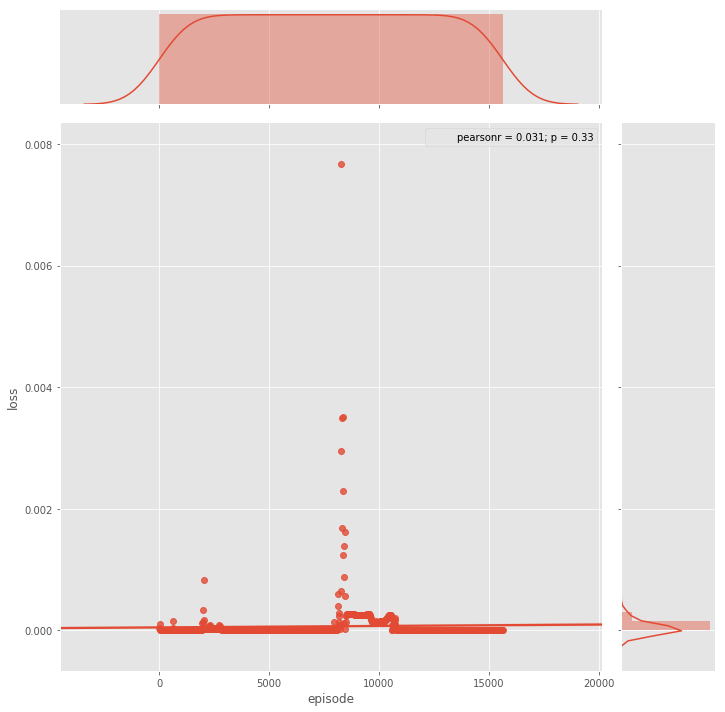

In [18]:
# show progress
df=pd.DataFrame(reports)
g = sns.jointplot(x="episode", y="loss", data=df, kind="reg", size=10)
plt.show()

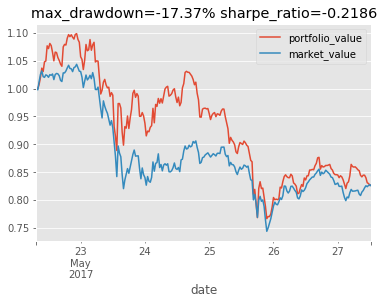

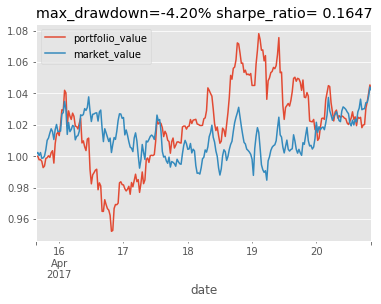

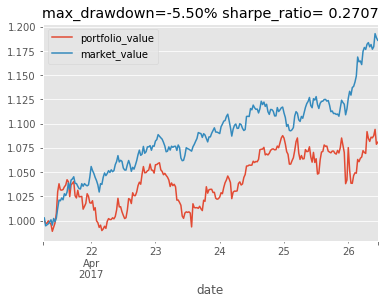

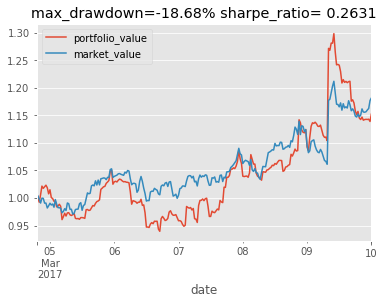

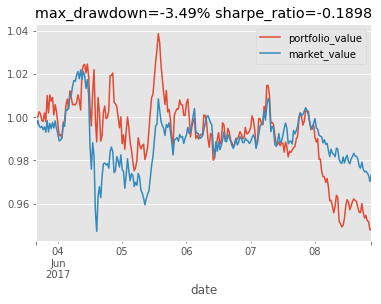

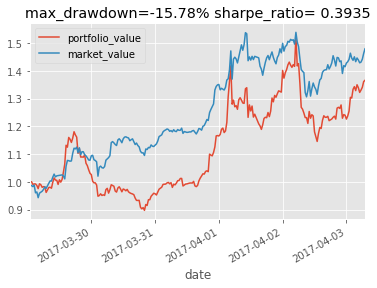

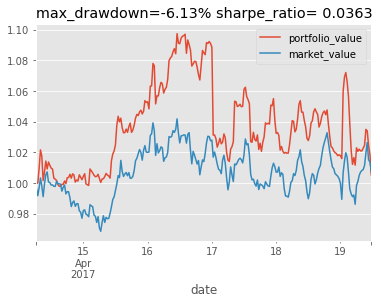

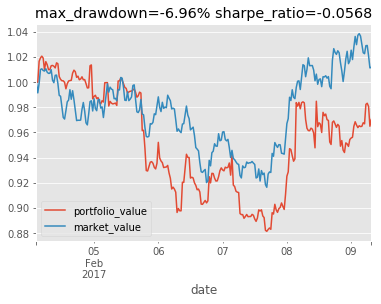

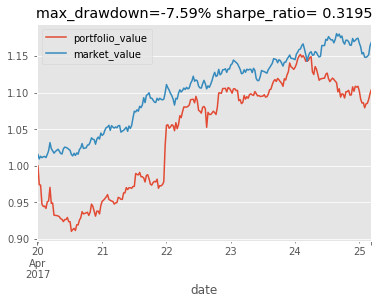

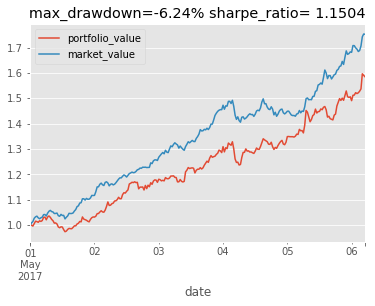

In [19]:
# env_test = env

# Test
for i in range(10):
    model.train(False)
    state = env_test.reset()
    for i in range(250):
        state = Variable(torch.Tensor(state).unsqueeze(0))
        mu, sigma_sq, v = model(state)
        eps = torch.randn(mu.size())
        action = (mu + sigma_sq.sqrt() * Variable(eps))
        env_action = action.data.squeeze().numpy()
        state, reward, done, info = env_test.step(env_action)
        if done:
            break

    env_test.plot()